In [1]:
import sys

import matplotlib.pyplot as plt

import numpy as np
import torch

sys.path.insert(0, "../")

%load_ext autoreload
%autoreload 2

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import src

In [3]:
device = "cuda:0"

In [4]:
from src.datasets.threedpw import ThreeDPW
from src.datasets.datasets_common import UNNORMALIZE
ds = ThreeDPW(set="train", seqlen=16, debug=True)
idx = 100
img = ds[idx]["video"].to(device)
img_orig = UNNORMALIZE(img) / 255
print(img.shape)

3DPW Dataset overlap ratio:  0.0
Loaded 3dpw dataset from /cvlabdata2/home/davydov/videoHMR_SSL/data/3dpw/3dpw_processed/train/3dpw_train_db.pt
3dpw - number of dataset objects 1403
torch.Size([16, 3, 224, 224])


In [5]:
from src.models.hmr import get_hmr
hmrnet = get_hmr(pretrained=True)
ckpt = "/cvlabdata2/home/davydov/videoHMR_SSL/eft_model_zoo/coco-all.pt"
ckpt = torch.load(ckpt, map_location="cpu")["hmrnet_state_dict"]
hmrnet.load_state_dict(ckpt)
hmrnet = hmrnet.to(device)
hmrnet.eval();

/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/cvlabdata2/home/davydov/miniconda3/envs/hmr_ssl/lib/python3.10/site-packages/torch/hub.py:704: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


In [15]:
from src.functional.texturepose import unproject_texture_to_vertices

In [37]:
img = img.to(device)

batch_size = img.size(0)
img_size = img.size(-1)

pred_smpl_rotmat, pred_smpl_shape, pred_camera = hmrnet(img)

from src.functional import smpl
smpl_model_49 = smpl.get_smpl_model("extra", device=device)

pred_out = smpl_model_49(
    betas=pred_smpl_shape,
    body_pose=pred_smpl_rotmat[:, 1:],
    global_orient=pred_smpl_rotmat[:, :1],
    pose2rot=False,
)

j3d = pred_out.joints
verts3d = pred_out.vertices

# use predicted camera parameters
scale, trans = pred_camera[:, 0], pred_camera[:, 1:]

verts3d = verts3d * scale.view(verts3d.size(0), 1, 1)
verts3d[:, :, 0:2] = verts3d[:, :, 0:2] + trans.view(verts3d.size(0), 1, 2)
verts3d_bbox = (verts3d + 1) / 2 * img_size

faces = smpl_model_49.faces.astype(int)
faces_batch = torch.tensor(faces.copy()).unsqueeze(0)

from src.functional.renderer import (
    ColoredRenderer,
    convert_vertices_to_mesh,
    fit_vertices_to_orthographic,
    render_mesh_onto_image,
    get_default_cameras,
    unproject_to_vertices,
)
cameras = get_default_cameras(device, mode="orthographic")

verts_rgb, vis_mask = unproject_texture_to_vertices(verts3d_bbox, img_orig, faces_batch, cameras)

verts_rgb_masked = verts_rgb * vis_mask.unsqueeze(-1)




faces_batch = torch.tensor(faces.copy()).unsqueeze(0).repeat(batch_size, 1, 1).to(device)

img_size = img_orig.shape[-2:]
colorbody_renderer_rgb = ColoredRenderer(img_size=img_size, device=device)
colorbody_renderer_neutral = ColoredRenderer(img_size=img_size, device=device, 
                                             specular_color=True, diffuse_color=True)

# visualize
verts3d_ndc = fit_vertices_to_orthographic(verts3d_bbox.clone(), img_size)
meshes_neutral = convert_vertices_to_mesh(verts3d_ndc, faces_batch)
render_images_neutral = colorbody_renderer_neutral(meshes_neutral)
blend_neutral = render_mesh_onto_image(img_orig.permute(0,2,3,1), render_images_neutral)

meshes_rgb = convert_vertices_to_mesh(verts3d_ndc, faces_batch, verts_rgb_colors=verts_rgb)
render_images_rgb = colorbody_renderer_rgb(meshes_rgb)
render_images_rgb = render_mesh_onto_image(torch.ones_like(render_images_rgb), render_images_rgb)

print(render_images_rgb.shape)

# faces_batch = torch.tensor(faces.copy()).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
# img_size = img.shape[-2:]

# from src.functional.renderer import (
#     ColoredRenderer,
#     convert_vertices_to_mesh,
#     fit_vertices_to_orthographic,
#     get_vertex_visibility_mask,
#     render_mesh_onto_image,
#     unproject_to_vertices,
#     get_default_cameras,
# )

# cameras = get_default_cameras(device, mode="orthographic")

# verts3d_ndc = fit_vertices_to_orthographic(verts3d_bbox.clone(), img_size)

# meshes = convert_vertices_to_mesh(verts3d_ndc, faces_batch)
# vis_mask = get_vertex_visibility_mask(meshes, cameras, img_size)
# vis_mask = vis_mask.view(verts3d_ndc.size(0), verts3d_ndc.size(1))

# ### extract colors
# verts_rgb = unproject_to_vertices(img_orig, verts3d_ndc)

# verts_rgb_masked = verts_rgb * vis_mask.unsqueeze(-1)

# colorbody_renderer_rgb = ColoredRenderer(img_size=img_size, device=device)
# colorbody_renderer_neutral = ColoredRenderer(img_size=img_size, device=device, 
#                                              specular_color=True, diffuse_color=True)

# # visualize
# meshes_neutral = convert_vertices_to_mesh(verts3d_ndc, faces_batch)
# render_images_neutral = colorbody_renderer_neutral(meshes_neutral)
# blend_neutral = render_mesh_onto_image(img_orig.permute(0,2,3,1), render_images_neutral)

# meshes_rgb = convert_vertices_to_mesh(verts3d_ndc, faces_batch, verts_rgb_colors=verts_rgb)
# render_images_rgb = colorbody_renderer_rgb(meshes_rgb)
# render_images_rgb = render_mesh_onto_image(torch.ones_like(render_images_rgb), render_images_rgb)

torch.Size([16, 224, 224, 3])


In [38]:
def plot_image_line(imgs):
    num = len(imgs)
    imgs = torch.cat(tuple(imgs), dim=1)
    fig, ax = plt.subplots(1,1, figsize=(num * 3, 3))
    ax.imshow(imgs)
    ax.set_axis_off()
    fig.tight_layout()
    fig.subplots_adjust()
    fig.patch.set_facecolor("white")

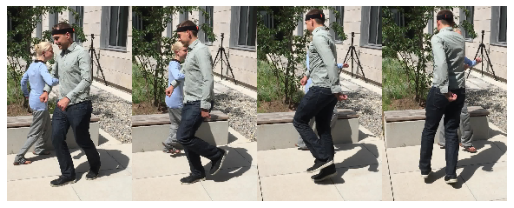

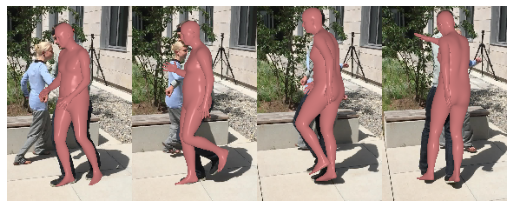

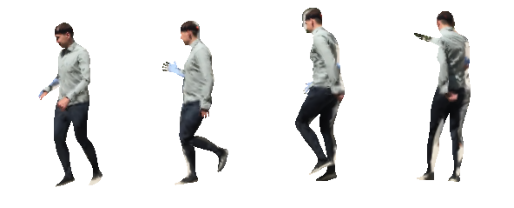

In [39]:
img_orig_ = img_orig.permute(0,2,3,1).detach().cpu()[::4][:,:,40:-40]
plot_image_line(img_orig_)

blend_neutral_ = blend_neutral.detach().cpu()[::4][:,:,40:-40]
plot_image_line(blend_neutral_)

render_images_rgb_ = render_images_rgb.detach().cpu()[::4][:,:,40:-40]
plot_image_line(render_images_rgb_)

In [40]:
import math
verts_rgb_masked_ = verts_rgb_masked.clone()
verts_rgb_masked_[verts_rgb_masked_ == 0] = 0.01

# dummy_smpl
dummy_betas = pred_smpl_shape
dummy_rot = torch.zeros_like(pred_smpl_rotmat)[...,0]
dummy_rot[:,0,0] = torch.pi
pred_out = smpl_model_49(
    betas=dummy_betas,
    body_pose=dummy_rot[:, 1:],
    global_orient=dummy_rot[:, :1],
    pose2rot=True,
)
verts3d = pred_out.vertices / 1.1
verts3d_bbox = (verts3d + 1) / 2 * 224
verts3d_bbox_dummy = verts3d_bbox.clone().detach()
verts3d_dummy_ndc = fit_vertices_to_orthographic(verts3d_bbox_dummy.clone(), img_size)

In [41]:
verts3d_dummy_ndc[:,:,0].shape

torch.Size([16, 6890])

In [42]:
# angles = [0, 60, 120, 180, 240, 300]
angles = [0, 180]
rot_images = []
for angle in angles:
    ### prepare back vertices
    c = math.cos(angle / 360 * 2 * math.pi)
    s = math.sin(angle / 360 * 2 * math.pi)
    verts3d_dummy_rot = verts3d_dummy_ndc.clone()
    verts_z_mean = verts3d_dummy_rot[:,:,2].mean()
    verts_x = verts3d_dummy_rot[:, :, 0] * c - (verts3d_dummy_rot[:, :, 2] - verts_z_mean) * s
    verts_z = verts3d_dummy_rot[:, :, 0] * s + (verts3d_dummy_rot[:, :, 2] - verts_z_mean) * c
    verts3d_dummy_rot[:, :, 0] = verts_x
    verts3d_dummy_rot[:, :, 2] = verts_z + verts_z_mean
    
    meshes_dummy_rgb = convert_vertices_to_mesh(verts3d_dummy_rot, faces_batch, verts_rgb_colors=verts_rgb_masked_)
    dummy_rgb = colorbody_renderer_rgb(meshes_dummy_rgb)
    dummy_rgb = render_mesh_onto_image(torch.ones_like(dummy_rgb), dummy_rgb)
    
    rot_images.append(dummy_rgb)

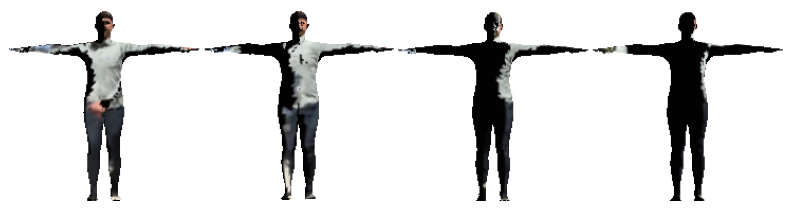

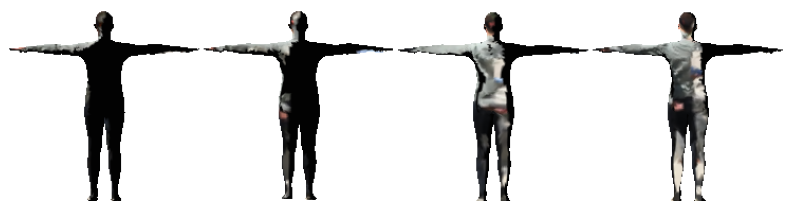

In [43]:
for dummy_rgb in rot_images:
    dummy_rgb_ = dummy_rgb.detach().cpu()[::4][:,:-40,20:-20]
    plot_image_line(dummy_rgb_)

In [44]:
verts_rgb

tensor([[[0.1960, 0.1144, 0.0977],
         [0.8489, 0.6411, 0.5784],
         [0.7954, 0.5840, 0.5183],
         ...,
         [0.5303, 0.3855, 0.3179],
         [0.5231, 0.3670, 0.3036],
         [0.6858, 0.4902, 0.4370]],

        [[0.1614, 0.0575, 0.0477],
         [0.6869, 0.4874, 0.4123],
         [0.6360, 0.4469, 0.3737],
         ...,
         [0.6325, 0.4823, 0.4189],
         [0.5914, 0.4439, 0.3850],
         [0.7495, 0.5773, 0.5029]],

        [[0.1207, 0.0941, 0.0753],
         [0.6614, 0.4555, 0.4011],
         [0.6674, 0.4568, 0.4004],
         ...,
         [0.5249, 0.3960, 0.3462],
         [0.5167, 0.3948, 0.3493],
         [0.5941, 0.4518, 0.3954]],

        ...,

        [[0.7750, 0.5581, 0.5008],
         [0.5494, 0.2696, 0.2611],
         [0.4583, 0.2908, 0.2441],
         ...,
         [0.2300, 0.1300, 0.1037],
         [0.2200, 0.1326, 0.1036],
         [0.2386, 0.1306, 0.1047]],

        [[0.6328, 0.4784, 0.3901],
         [0.9320, 0.7756, 0.6159],
         [0.

In [45]:
verts3d_ndc_to_opt = verts3d_ndc.clone().detach()
verts3d_ndc_to_opt.requires_grad = True

verts_rgb = unproject_to_vertices(img_orig, verts3d_ndc_to_opt)

verts_rgb.sum().backward()

In [47]:
verts3d_ndc_to_opt.grad.shape

torch.Size([16, 6890, 3])